# GP for $X_{hh}$

**Motivation:** Sean built a GP to do an interpolation for $(m_{H1},m_{H2})$, but we _haven't_ evaluated an error bar on this prediction yet. I.e, see the plot below from Sean's + my $21^{st}$ Jan 2021
[talk](https://indico.cern.ch/event/999043/contributions/4198831/attachments/2175931/3674485/GP-flows-combination.pdf).

<img src="figures/Sean-GP-marginals-17.png" width=500>


I think that it makes sense to see what the error bar on the plot is _just_ from the GP, and then we can try propagating it forward to the higher level (and categorization) variable: $X_{hh}$.

In [112]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import combinations
from glob import glob
from time import time
from tqdm import tqdm 

import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import pearsonr

from plotUtils import significance

import os
os.sys.path += ['../GraphNN/','../Flow-Models/','../gp-for-flows/','../PyATLASstyle/','../code/'] 

from gp import *
#from bkgPred import *
# from densityEstimate import *
# from densityPlots import *

from plotting import SR_x,SR_y1,SR_y2, CR_x,CR_y1,CR_y2, SB_x,SB_y1,SB_y2

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

import matplotlib as mpl
mpl.rcParams.update({'figure.max_open_warning': 0})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


## Step 1: Load in the data

Rn I'm doing this w/ pag so I can copy + paste my code from the `Combine-GP` nb, but I'll try to do this agnostically so that I can propagate forward to the min_dR pairing.

In [2]:
yr = 17

In [3]:
# '''
# Uncomment this cell for pag
# '''
# subDir = f'data{yr}_PFlow-FEB20-5jets'
# tag = '_SM_2b_p_0.01'
# seedTag = ''
# prodTag = 'FEB20'
# ntag = 2

# cols = ['log_pT_h1','log_pT_h2','eta_h1','eta_h2','log_dphi_hh']
# colTag = '_'.join(cols)
# s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'
# d = data(5, yr, prodTag, tag, ntag, s)

# deta_cut = (d.df.abs_deta_hh < 1.5)  
# d.mlPrepare(deta_cut,cols,N=-1)

In [4]:
# Load in the pag dataset
fin = '../data/data17_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5'

df = pd.read_hdf( fin )

**Recall:** This is a dataset that
1. Doesn't have the $\Delta \eta_{hh}$ cut - so need to apply it
2. Also doesn't have the VBF veto _or_ the trig bucket cuts... but that is fine (for now)

In [5]:
df['X_hh'] = Xhh(df['m_h1'],df['m_h2'])

In [134]:
low_bounds=[126 - 45, 116 - 45]
high_bounds=[126 + 45, 116 + 45]

In [135]:
extent = [low_bounds[0], high_bounds[0], low_bounds[1], high_bounds[1]]

In [136]:
deta_cut = (df['abs_deta_hh'] < 1.5) & (df.ntag==2)

full_data = df[deta_cut]
nbinsx,nbinsy = 50,50

#Train on full box - SR will be blinded in training
bins = [np.linspace(*extent[:2], nbinsx+1), 
        np.linspace(*extent[2:], nbinsy+1)]

density = GPdensity(full_data, bins, blind=True)
density.train()

nBlind = np.sum(deta_cut & (df['X_hh'] > 1.6)) 
nPreds = 10

nEvents = nBlind * nPreds
m1,m2 = density.sample(nEvents)

../gp-for-flows/gp.py:65: RuntimeWarning: divide by zero encountered in true_divide
  stat_err = (np.maximum(bkgd_2d, np.ones(bkgd_2d.shape)) / bkgd_2d).flatten()


RBF(length_scale=[51.8, 61.1])


In [137]:
np.sum((df['X_hh'] < 1.6) & deta_cut)

8082

In [138]:
nEvents

2151780

In [139]:
m1_up, m2_up = density.sample(nEvents, mode='+1sig')
m1_dn, m2_dn = density.sample(nEvents, mode='-1sig')

In [140]:
xhh    = Xhh(m1,   m2)
xhh_up = Xhh(m1_up,m2_up)
xhh_dn = Xhh(m1_dn,m2_dn)

SR    = (xhh    < 1.6)
SR_up = (xhh_up < 1.6)
SR_dn = (xhh_dn < 1.6)

In [142]:
n_out = np.sum(box_sel(full_data, *extent)['X_hh'] > 1.6)

In [143]:
yields = []

for i in tqdm( range(250) ):
    yields.append( density.getNorm() )
    
yields = np.array(yields)

100%|██████████| 250/250 [05:22<00:00,  1.29s/it]


In [146]:
yields.mean()

8167.483970978194

In [147]:
N_SR_true = np.sum(full_data['X_hh'] < 1.6)

In [148]:
yields.mean()/N_SR_true

1.0105770812890613

**1% level error on the mean...** 

Is this expected?

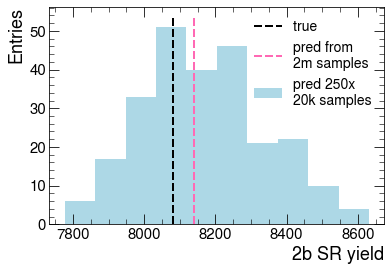

In [254]:
plt.hist(yields,color='lightblue',label='pred 250x\n20k samples')

ylim = plt.ylim()
plt.plot([np.sum(full_data['X_hh'] < 1.6)]*2,ylim,'k--',lw=2,label='true ')

plt.xlabel('2b SR yield',ha='right',x=1,fontsize=18)
plt.ylabel('Entries',ha='right',y=1,fontsize=18)

plt.legend()

plt.plot([(n_out/np.sum(xhh>1.6)) * np.sum(xhh <1.6)]*2,ylim,
         'hotpink',ls='--',lw=2,label=f'pred from\n2m samples')
plt.legend()

plt.savefig(f'{figDir}/normPred.pdf',bbox_inches='tight')

plt.show()

In [240]:
yields.mean()

8167.483970978194

**Need to sort out why the pink is off...**

In [246]:
N_SR_samp = (n_out/np.sum(xhh>1.6)) * np.sum(xhh <1.6)

In [263]:
yields.mean() / N_SR_true

1.0105770812890613

In [264]:
N_SR_samp / N_SR_true

1.0071733470790531

In [213]:
n_2b,ex,ey,_ =  plt.hist2d(full_data['m_h1'],full_data['m_h2'],
                           [nbinsx,nbinsy], [extent[:2],extent[2:]],
                           cmap='magma_r')

plt.plot(np.concatenate([SR_x,SR_x[::-1]]),
         np.concatenate([SR_y1,SR_y2[::-1]]),
         'mediumturquoise')

plt.plot(np.concatenate([CR_x,CR_x[::-1]]),
         np.concatenate([CR_y1,CR_y2[::-1]]),
         'mediumturquoise',ls='--')

plt.plot(np.concatenate([SB_x,SB_x[::-1]]),
         np.concatenate([SB_y1,SB_y2[::-1]]),
         'mediumturquoise',ls='dotted')

plt.colorbar()

plt.xlabel('$\mathrm{m_{H1}}$ [GeV]',fontsize=18,ha='right',x=1)
plt.ylabel('$\mathrm{m_{H2}}$ [GeV]',fontsize=18,ha='right',y=1)
    
plt.show()

In [214]:
len(ex)

51

In [238]:
figDir = f'figures/GP-err/pag-2b-{yr}/'

In [215]:
xx = 0.5 * (ex[:-1] + ex[1:])
yy = 0.5 * (ey[:-1] + ey[1:])

xx,yy = np.meshgrid(xx,yy)

In [216]:
xx.shape,yy.shape

((50, 50), (50, 50))

In [217]:
sr_xy = np.sqrt(((xx-120) / (.1 * xx))**2 + ((yy-110) / (.1 * yy))**2) < 1.6

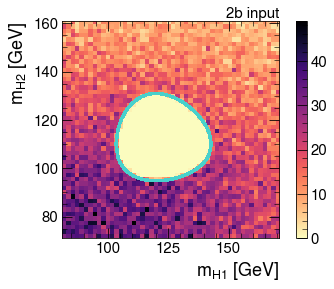

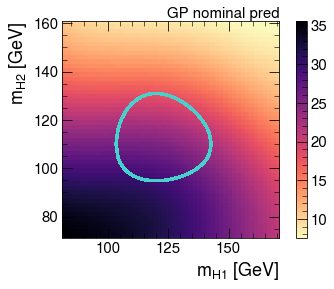

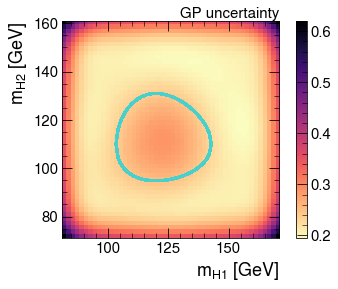

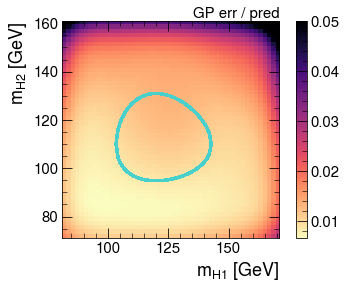

In [219]:
for img,text,vmax in zip([density.bkgd,density.pred, density.uncert, density.uncert/ density.pred],
                         ['2b input','GP nominal pred','GP uncertainty','GP err / pred'],
                         [None,None,None,0.05]):

    fig = plt.figure()
    plt.imshow(img.reshape(50,50).T,
               cmap='magma_r',vmax=vmax, 
               origin='lower',extent=extent)

    plt.plot(np.concatenate([SR_x,SR_x[::-1]]),
             np.concatenate([SR_y1,SR_y2[::-1]]),
             'mediumturquoise')

    plt.colorbar()
    
    plt.xlabel('$\mathrm{m_{H1}}$ [GeV]',fontsize=18,ha='right',x=1)
    plt.ylabel('$\mathrm{m_{H2}}$ [GeV]',fontsize=18,ha='right',y=1)
    
    ax = plt.gca()
    plt.text(1,1,text,ha='right',va='bottom',transform=ax.transAxes)
    
    figName = text.replace(' ','_').replace('/','by')
    plt.savefig(f'{figDir}/{figName}.pdf',bbox_inches='tight')
    
    

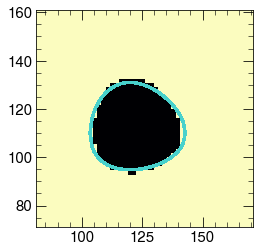

In [235]:
plt.imshow(#density.bkgd.reshape(50,50).T,
           #sr_xy.T,
           np.where(sr_xy,img.reshape(50,50),0).T,
           cmap='magma_r',#vmax=vmax, 
           origin='lower',extent=extent)

plt.plot(np.concatenate([SR_x,SR_x[::-1]]),
         np.concatenate([SR_y1,SR_y2[::-1]]),
         'mediumturquoise')

In [237]:
img.reshape(50,50)[sr_xy].mean()

0.011147330310597482

Text(0, 1, '$\\mathrm{m_{H2}}$ [GeV]')

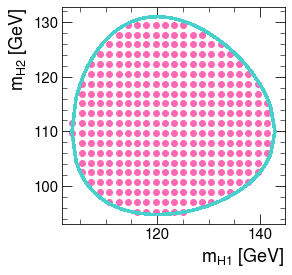

In [218]:
plt.figure(figsize=(4,4))

plt.scatter(xx[sr_xy],yy[sr_xy],color='hotpink')

plt.plot(np.concatenate([SR_x,SR_x[::-1]]),
         np.concatenate([SR_y1,SR_y2[::-1]]),
         'mediumturquoise')

plt.xlabel('$\mathrm{m_{H1}}$ [GeV]',fontsize=18,ha='right',x=1)
plt.ylabel('$\mathrm{m_{H2}}$ [GeV]',fontsize=18,ha='right',y=1)

In [39]:
gpr.log_marginal_likelihood_value_

-1376.7576962483804

<ipython-input-260-08d8d473bf85>:53: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,up/pred,'hotpink',lw=lw)
<ipython-input-260-08d8d473bf85>:54: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,dn/pred,'C9',lw=lw)
<ipython-input-260-08d8d473bf85>:56: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,n_2b/pred, np.sqrt(n_2b)/pred,color='k',lw=0,elinewidth=lw,
<ipython-input-260-08d8d473bf85>:53: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,up/pred,'hotpink',lw=lw)
<ipython-input-260-08d8d473bf85>:54: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,dn/pred,'C9',lw=lw)
<ipython-input-260-08d8d473bf85>:56: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,n_2b/pred, np.sqrt(n_2b)/pred,color='k',lw=0,elinewidth=lw,
<ipython-input-260-08d8d473bf85>:53: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,up/pred,'hotpink',lw=lw)
<

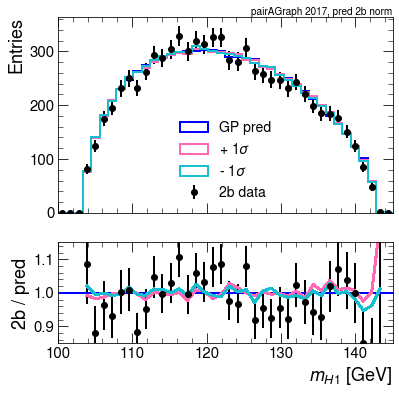

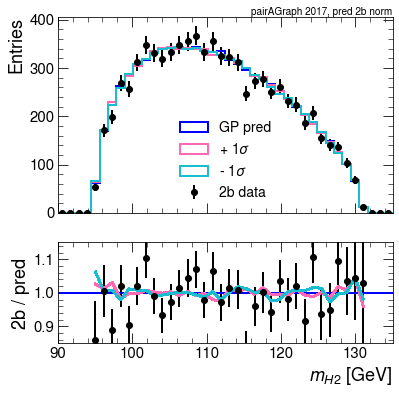

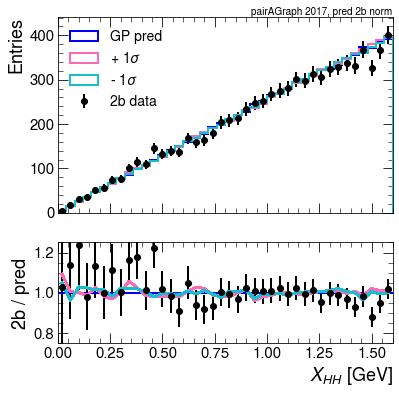

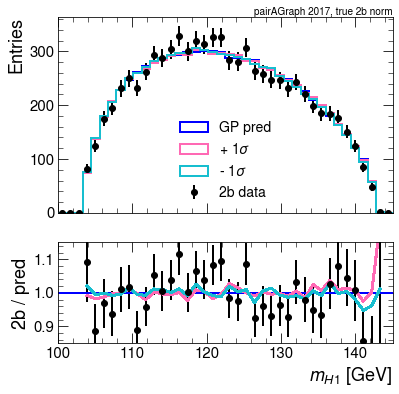

In [260]:
nb=40
lw=2

#N_SR_pred = #np.array(yields).mean() 
N_SR_true = np.sum(deta_cut & (df['X_hh'] < 1.6))

for N_SR,tag in zip([N_SR_samp,N_SR_true],['pred','true']):

    for mi,mi_up,mi_dn,c,xl,ri,rlim in zip([m1, m2, xhh],
                                           [m1_up,m2_up,xhh_up],
                                           [m1_dn,m2_dn,xhh_dn],
                                           ['m_h1','m_h2','X_hh'],
                                           ['$m_{H1}$ [GeV]','$m_{H2}$ [GeV]','$X_{HH}$ [GeV]'],
                                           [(100,145),(90,135),(0,1.6)],
                                           [(0.85,1.15),(0.85,1.15),(0.75,1.25)]):

        fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,6),
                                      gridspec_kw={'height_ratios':[.66,.34]})

        pred = ax1.hist(mi[SR],nb,ri,histtype='step',lw=lw,color='b',label='GP pred',
                        weights=np.ones_like(mi[SR]) * N_SR / len(mi[SR]))[0]


        # Let's viz the error bars tooooo!
        up = ax1.hist(mi_up[SR_up],nb,ri,histtype='step',lw=lw,color='hotpink',label='+ 1$\sigma$',
                        weights=np.ones_like(mi_up[SR_up]) * N_SR / len(mi_up[SR_up]))[0]
        dn = ax1.hist(mi_dn[SR_dn],nb,ri,histtype='step',lw=lw,color='C9',label='- 1$\sigma$',
                        weights=np.ones_like(mi_dn[SR_dn]) * N_SR / len(mi_dn[SR_dn]))[0]


        n_2b, e = np.histogram(df.loc[deta_cut & (df['X_hh'] < 1.6),c],nb,ri)

        xx = 0.5 * (e[1:] + e[:-1])

        ax1.errorbar(xx,n_2b, np.sqrt(n_2b),color='k',lw=0,elinewidth=lw,
                     marker='o',label='2b data')

        ax2.set_xlim(ri)
        ax2.set_ylim(rlim)

        ax2.set_xlabel(xl,fontsize=18,ha='right',x=1)

        ax1.set_ylabel('Entries',fontsize=18,ha='right',y=1)
        ax2.set_ylabel('2b / pred',fontsize=18)

        ax1.legend()

        '''
        And now the subpanel!
        '''
        ax2.plot(ri,[1]*2,'b',lw=lw)

        ax2.plot(xx,up/pred,'hotpink',lw=lw)
        ax2.plot(xx,dn/pred,'C9',lw=lw)

        ax2.errorbar(xx,n_2b/pred, np.sqrt(n_2b)/pred,color='k',lw=0,elinewidth=lw,
                     marker='o',label='2b data')

        ax1.text(1,1,f'pairAGraph 20{yr}, {tag} 2b norm',fontsize=10,
                 ha='right',va='bottom',transform=ax1.transAxes)
        
        plt.savefig(f'{figDir}/{c}_{tag}.pdf',bbox_inches='tight')
        
        

I should *zoom* in on the  the points at the end b/c it *is* pretty cool that we have the error increasing as we go away from where the data is trained.

For completeness, let's **compare** these two options for getting the norm here!!

<ipython-input-266-140c6f652653>:45: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,n_2b/pred, np.sqrt(n_2b)/pred,color='k',lw=0,elinewidth=lw,
<ipython-input-266-140c6f652653>:48: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,true/pred,color='b',ls='--')
<ipython-input-266-140c6f652653>:45: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,n_2b/pred, np.sqrt(n_2b)/pred,color='k',lw=0,elinewidth=lw,
<ipython-input-266-140c6f652653>:48: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(xx,true/pred,color='b',ls='--')


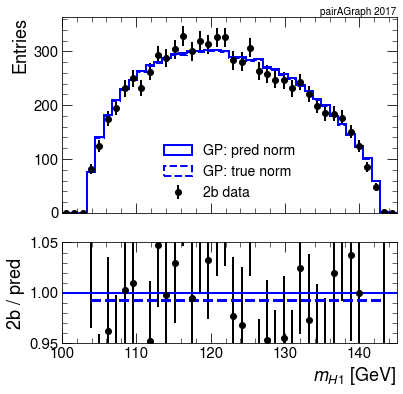

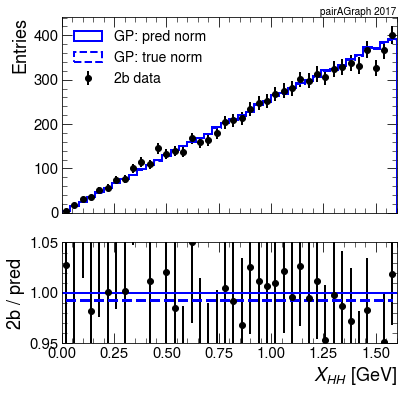

In [266]:
#for N_SR,tag in zip([N_SR_pred,N_SR_true],['pred','true']):

for mi,mi_up,mi_dn,c,xl,ri,rlim in zip([m1, m2, xhh],
                                       [m1_up,m2_up,xhh_up],
                                       [m1_dn,m2_dn,xhh_dn],
                                       ['m_h1','m_h2','X_hh'],
                                       ['$m_{H1}$ [GeV]','$m_{H2}$ [GeV]','$X_{HH}$ [GeV]'],
                                       [(100,145),(90,135),(0,1.6)],
                                       [(0.95,1.05)]*3
                                       #[(0.85,1.15),(0.85,1.15),(0.75,1.25)]
                                      ):

        fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(6,6),
                                      gridspec_kw={'height_ratios':[.66,.34]})

        pred = ax1.hist(mi[SR],nb,ri,histtype='step',lw=lw,color='b',label='GP: pred norm',
                        weights=np.ones_like(mi[SR]) * N_SR_samp / len(mi[SR]))[0]
        
        true = ax1.hist(mi[SR],nb,ri,histtype='step',
                        lw=lw,ls='--',color='b',label='GP: true norm',
                        weights=np.ones_like(mi[SR]) * N_SR_true / len(mi[SR]))[0]

        n_2b, e = np.histogram(df.loc[deta_cut & (df['X_hh'] < 1.6),c],nb,ri)

        xx = 0.5 * (e[1:] + e[:-1])

        ax1.errorbar(xx,n_2b, np.sqrt(n_2b),color='k',lw=0,elinewidth=lw,
                     marker='o',label='2b data')

        ax2.set_xlim(ri)
        ax2.set_ylim(rlim)

        ax2.set_xlabel(xl,fontsize=18,ha='right',x=1)

        ax1.set_ylabel('Entries',fontsize=18,ha='right',y=1)
        ax2.set_ylabel('2b / pred',fontsize=18)

        ax1.legend()

        '''
        And now the subpanel!
        '''
        ax2.plot(ri,[1]*2,'b',lw=lw)

        ax2.errorbar(xx,n_2b/pred, np.sqrt(n_2b)/pred,color='k',lw=0,elinewidth=lw,
                     marker='o',label='2b data')
        
        ax2.plot(xx,true/pred,color='b',ls='--')

        ax1.text(1,1,f'pairAGraph 20{yr}',fontsize=10,
                 ha='right',va='bottom',transform=ax1.transAxes)
        
        plt.savefig(f'{figDir}/{c}_norm_true_vs_pred.pdf',bbox_inches='tight')
        
        

## Adding errors to the GP

**Question:** How would these conclusion change if we instead included error bars in the GP fit?

According to [this example](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html), it seems like this is just as easy as passing the estimated errors to the GPR.

**Note: Sean is already doing this => no need to worry about it**